### PTB Dataset

In [8]:
import wfdb
import numpy as np
import random
import os
import pywt
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt


def load_lead_ii(record_path):
    record = wfdb.rdrecord(record_path)
    lead_ii = record.p_signal[:, 0]
    return lead_ii

def add_random_distortion(ecg_signal, fs=360):
    t = np.linspace(0, len(ecg_signal)/fs, len(ecg_signal), endpoint=False)
    
    def add_powerline_interference(signal):
        power_line_frequency = 60
        pli_amplitude = np.random.uniform(0.05, 0.15) * np.max(signal)
        pli_signal = pli_amplitude * np.sin(2 * np.pi * power_line_frequency * t)
        return signal + pli_signal

    def add_baseline_wander(signal):
        baseline_wander_frequency = np.random.uniform(0.1, 1)
        baseline_wander_amplitude = np.random.uniform(0.02, 0.07) * np.max(signal)
        baseline_wander = baseline_wander_amplitude * np.sin(2 * np.pi * baseline_wander_frequency * t)
        return signal + baseline_wander

    def add_gaussian_noise(signal):
        noise_amplitude = np.random.uniform(0.005, 0.02) * np.max(signal)
        noise = noise_amplitude * np.random.normal(size=len(signal))
        return signal + noise

    def add_random_spikes(signal):
        num_spikes = np.random.randint(5, 20)
        spike_amplitude = np.random.uniform(0.1, 0.3) * np.max(signal)
        spike_indices = np.random.choice(len(signal), num_spikes, replace=False)
        signal_with_spikes = np.copy(signal)
        for index in spike_indices:
            spike = spike_amplitude * (np.random.choice([-1, 1]))
            signal_with_spikes[index] += spike
        return signal_with_spikes

    def corrupt_wavelet_coefficients(signal):
        coeffs = pywt.wavedec(signal, 'db4', level=4)
        level_to_corrupt = np.random.choice(range(1, 3))
        corruption_strength = np.random.uniform(0.05, 0.2)
        coeffs[level_to_corrupt] += corruption_strength * np.random.randn(*coeffs[level_to_corrupt].shape)
        corrupted_signal = pywt.waverec(coeffs, 'db4')
        return corrupted_signal[:len(signal)]

    distortions = [
        add_powerline_interference, 
        add_baseline_wander, 
        add_gaussian_noise, 
        add_random_spikes,
#         corrupt_wavelet_coefficients
    ]
    
    chosen_distortion = random.choice(distortions)
    distorted_signal = chosen_distortion(ecg_signal)
    
    
    return distorted_signal

def extract_10sec_windows(lead_ii, num_samples=180, window_size=360*10):
    windows = []
    total_length = len(lead_ii)
    max_windows = total_length // window_size
    num_samples=max_windows

#     if max_windows < num_samples:
#         num_samples=max_windows
# #         raise ValueError(f"Cannot extract {num_samples} non-overlapping windows, only {max_windows} available.")
    
    for i in range(num_samples):
        start = i * window_size
        end = start + window_size
        window = lead_ii[start:end]
        windows.append(window)
    
    return np.array(windows)

def scale_signal(signal):
    min_val = np.min(signal)
    max_val = np.max(signal)
    return (signal - min_val) / (max_val - min_val)
import wfdb
import numpy as np
import random
import os
import pywt
def load_lead_ii(record_path):
    # Load the ECG record using wfdb
    record = wfdb.rdrecord(record_path)
#     print(wfdb.rdheader(record_path).fs)
#     print(wfdb.rdheader(record_path).fs)

    # Extract Lead II (usually the second channel)
    lead_ii = record.p_signal[:, 1]  # Assuming Lead II is the second lead
    return lead_ii



import numpy as np

def extract_1_minute_windows(lead_ii,fs):
    window_size=int(fs)*10
    windows = []
    total_length = len(lead_ii)
    
    # Calculate the number of possible non-overlapping windows
    max_windows = total_length // window_size
    num_samples=max_windows
    
#     if max_windows < num_samples:
#         raise ValueError(f"Cannot extract {num_samples} non-overlapping windows, only {max_windows} available.")
    
    # Extract non-overlapping windows
    for i in range(num_samples):
        start = i * window_size
        end = start + window_size
        window = lead_ii[start:end]
        windows.append(window)
    
    return np.array(windows)


def scale_signal(signal):
    # Scale the signal between 0 and 1
    min_val = np.min(signal)
    max_val = np.max(signal)
    return (signal - min_val) / (max_val - min_val)

def process_mit_bih_data(data_directory, num_samples=180):
    patient_data = {}
    p_id=0
    
    for patient in os.listdir(data_directory):
        patient_scalled_window=[]
        p_id=p_id+1
        for record in os.listdir(data_directory+'/'+patient):
#             print(record)
            if record.endswith('.dat'):
                
                
                record_name = os.path.splitext(record)[0]
                record_path =data_directory+'/'+patient+'/'+record_name

                # Load Lead II
#                 lead_ii = load_lead_ii(record_path)
                record = wfdb.rdrecord(record_path)
#                 print(wfdb.rdheader(record_path).fs)
#                 print(wfdb.rdheader(record_path).sig_name)
                fs=wfdb.rdheader(record_path).fs
                # Extract Lead II (usually the second channel)
                lead_ii = record.p_signal[:, 1]  # Assuming Lead II is the second lead

                # Extract 1-minute windows
                windows = extract_1_minute_windows(lead_ii ,fs)

                # Add distortions
                distorted_windows = np.array([add_random_distortion(window) for window in windows])

                # Scale the signals between 0 and 1
                scaled_windows = np.array([scale_signal(window) for window in windows])
            
                patient_scalled_window.append(scaled_windows)
        
        # Concatenate all accumulated windows into a single array for each patient
        patient_data[p_id] = np.concatenate(patient_scalled_window, axis=0)



    return patient_data


# Example usage
data_directory = 'ptb-diagnostic-ecg-database-1.0.0'
patient_data = process_mit_bih_data(data_directory)

# Now patient_data contains 30 distorted and scaled 1-minute windows for each patient.


In [2]:
from sklearn.model_selection import train_test_split
import numpy as np
from scipy.signal import resample

# Assuming `patient_data` is a dictionary with patient IDs as keys and their corresponding 1-minute ECG windows as values.

# Convert the dictionary to lists for processing
X = []
y = []

for patient_id, windows in patient_data.items():
    for window in windows:
        
        window = resample(window, 3600)

        X.append(window)
        y.append(patient_id)

X = np.array(X)
y = np.array(y)

In [6]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix, f1_score, accuracy_score
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np

# Load your CNN model
cnn_model = tf.keras.models.load_model('final_non_overlapping.h5', compile=False)

# Reshape the ECG data
ptbxl_X = X.reshape(-1, 3600, 1)
ptbxl_y = y

# Adjust the labels to start from 0
ptbxl_y = ptbxl_y - 1

ptb_X_train, ptb_X_test, ptb_y_train, ptb_y_test = train_test_split(ptbxl_X, ptbxl_y, test_size=0.2, random_state=42)

# Step 1: Generate embeddings for the test data
def generate_embeddings(model, X_):
    embeddings = model.predict(X_)
    return embeddings

# Generate embeddings for the train and test sets
embeddings_train = generate_embeddings(cnn_model, ptb_X_train)
embeddings_test = generate_embeddings(cnn_model, ptb_X_test)

# Step 2: Build a neural network classifier
def build_nn_classifier(input_shape, num_classes):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=input_shape))
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))  # Output layer for classification
    return model

# Get the number of classes from the unique labels
num_classes = len(np.unique(ptb_y_train))

# Build and compile the neural network classifier
nn_classifier = build_nn_classifier(input_shape=(embeddings_train.shape[1],), num_classes=num_classes)
nn_classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Step 3: Train the neural network classifier on the embeddings
history =nn_classifier.fit(embeddings_train, ptb_y_train, epochs=1000, batch_size=32, validation_split=0.1,verbose=0)

# Step 4: Use the neural network model to predict the class of each test embedding
predicted_labels = np.argmax(nn_classifier.predict(embeddings_test), axis=1)

# Step 5: Calculate accuracy, precision, recall, and confusion matrix
accuracy = accuracy_score(ptb_y_test, predicted_labels)
precision = precision_score(ptb_y_test, predicted_labels, average='macro')
recall = recall_score(ptb_y_test, predicted_labels, average='macro')
f1_score_ = f1_score(ptb_y_test, predicted_labels, average='macro')
conf_matrix = confusion_matrix(ptb_y_test, predicted_labels)

# Print the evaluation metrics
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("F1 Score: {:.2f}".format(f1_score_))
print("Confusion Matrix:\n", conf_matrix)


36/36 [==============================] - 0s 819us/step
Accuracy: 97.64%
Precision: 97.63%
Recall: 97.83%
F1 Score: 0.97
Confusion Matrix:
 [[5 0 0 ... 0 0 0]
 [0 4 0 ... 0 0 0]
 [0 0 2 ... 0 0 0]
 ...
 [0 0 0 ... 5 1 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 0 1]]


C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


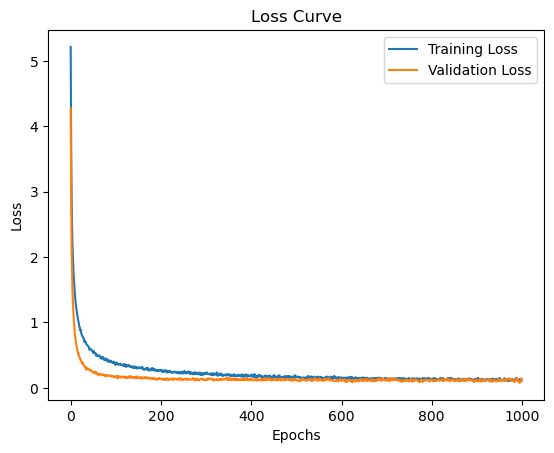

In [9]:
# Plotting the loss curves

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [13]:
X.shape

(5724, 3600)

# MIT BIH 

In [21]:
import wfdb
import numpy as np
import random
import os
import pywt
from sklearn.model_selection import train_test_split
import numpy as np


def load_lead_ii(record_path):
    record = wfdb.rdrecord(record_path)
    lead_ii = record.p_signal[:, 0]
    return lead_ii

def add_random_distortion(ecg_signal, fs=360):
    t = np.linspace(0, len(ecg_signal)/fs, len(ecg_signal), endpoint=False)
    
    def add_powerline_interference(signal):
        power_line_frequency = 60
        pli_amplitude = np.random.uniform(0.05, 0.15) * np.max(signal)
        pli_signal = pli_amplitude * np.sin(2 * np.pi * power_line_frequency * t)
        return signal + pli_signal

    def add_baseline_wander(signal):
        baseline_wander_frequency = np.random.uniform(0.1, 1)
        baseline_wander_amplitude = np.random.uniform(0.02, 0.07) * np.max(signal)
        baseline_wander = baseline_wander_amplitude * np.sin(2 * np.pi * baseline_wander_frequency * t)
        return signal + baseline_wander

    def add_gaussian_noise(signal):
        noise_amplitude = np.random.uniform(0.005, 0.02) * np.max(signal)
        noise = noise_amplitude * np.random.normal(size=len(signal))
        return signal + noise

    def add_random_spikes(signal):
        num_spikes = np.random.randint(5, 20)
        spike_amplitude = np.random.uniform(0.1, 0.3) * np.max(signal)
        spike_indices = np.random.choice(len(signal), num_spikes, replace=False)
        signal_with_spikes = np.copy(signal)
        for index in spike_indices:
            spike = spike_amplitude * (np.random.choice([-1, 1]))
            signal_with_spikes[index] += spike
        return signal_with_spikes

    def corrupt_wavelet_coefficients(signal):
        coeffs = pywt.wavedec(signal, 'db4', level=4)
        level_to_corrupt = np.random.choice(range(1, 3))
        corruption_strength = np.random.uniform(0.05, 0.2)
        coeffs[level_to_corrupt] += corruption_strength * np.random.randn(*coeffs[level_to_corrupt].shape)
        corrupted_signal = pywt.waverec(coeffs, 'db4')
        return corrupted_signal[:len(signal)]

    distortions = [
        add_powerline_interference, 
        add_baseline_wander, 
        add_gaussian_noise, 
        add_random_spikes,
#         corrupt_wavelet_coefficients
    ]
    
    chosen_distortion = random.choice(distortions)
    distorted_signal = chosen_distortion(ecg_signal)
    
    
    return distorted_signal

def extract_10sec_windows(lead_ii, num_samples=180, window_size=360*10):
    windows = []
    total_length = len(lead_ii)
    max_windows = total_length // window_size
    num_samples=max_windows

#     if max_windows < num_samples:
#         num_samples=max_windows
# #         raise ValueError(f"Cannot extract {num_samples} non-overlapping windows, only {max_windows} available.")
    
    for i in range(num_samples):
        start = i * window_size
        end = start + window_size
        window = lead_ii[start:end]
        windows.append(window)
    
    return np.array(windows)

def scale_signal(signal):
    min_val = np.min(signal)
    max_val = np.max(signal)
    return (signal - min_val) / (max_val - min_val)

def process_mit_bih_data(data_directory, num_samples=180):
    patient_data = {}
    
    for record in os.listdir(data_directory):
        if record.endswith('.dat'):
            record_name = os.path.splitext(record)[0]
            record_path = os.path.join(data_directory, record_name)
            
            lead_ii = load_lead_ii(record_path)
            
            total_duration = len(lead_ii) // 360
            if total_duration < 30:
                raise ValueError(f"Record {record_name} is shorter than 30 minutes.")

            # Split into 25-min train and 5-min test
            train_segment = lead_ii[:25*360*60]
            test_segment = lead_ii[25*360*60:]
            
            # Extract 1-minute windows from train segment
            train_windows = extract_10sec_windows(train_segment, num_samples)
            test_windows = extract_10sec_windows(test_segment, num_samples // 5)
            
            # Add distortions to both train and test segments
            distorted_train_windows = np.array([add_random_distortion(window) for window in train_windows])
            distorted_test_windows = np.array([add_random_distortion(window) for window in test_windows])
            
            # Scale the signals between 0 and 1
            scaled_train_windows = np.array([scale_signal(window) for window in distorted_train_windows])
            scaled_test_windows = np.array([scale_signal(window) for window in distorted_test_windows])
            
            # Store the data
            patient_data[record_name] = {
                'train': scaled_train_windows,
                'test': scaled_test_windows
            }
    
    return patient_data

# Example usage
data_directory = 'mit-bih-arrhythmia-database-1.0.0'
patient_data = process_mit_bih_data(data_directory)
import numpy as np
import os

def flatten_patient_data(patient_data):
    X_train = []
    X_test = []
    y_train = []
    y_test = []

    for record_name, data in patient_data.items():
        train_windows = data['train']
        test_windows = data['test']

        # Flatten the training and testing windows
        X_train.extend(train_windows)
        X_test.extend(test_windows)
#         compute_distances
        # Create labels
        num_train_samples = len(train_windows)
        num_test_samples = len(test_windows)

        y_train.extend([record_name] * num_train_samples)
        y_test.extend([record_name] * num_test_samples)

    # Convert lists to numpy arrays
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train).astype(int)
    y_test = np.array(y_test).astype(int)

    return X_train, X_test, y_train, y_test

# Example usage
X_train, X_test, y_train, y_test = flatten_patient_data(patient_data)


# Reshape X_train and X_test to match the input shape expected by the CNN (samples, length of ECG signal, 1)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Encode labels to integers
unique_labels = np.unique(y_train)
label_map = {label: index for index, label in enumerate(unique_labels)}
y_train = np.array([label_map[label] for label in y_train])
y_test = np.array([label_map[label] for label in y_test])

num_classes = len(unique_labels)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (7200, 3600, 1)
X_test shape: (1440, 3600, 1)
y_train shape: (7200,)
y_test shape: (1440,)


In [22]:
y_train

array([ 0,  0,  0, ..., 47, 47, 47])

In [23]:


ptb_X_train, ptb_X_test, ptb_y_train, ptb_y_test =X_train,X_test,y_train,y_test
# Generate embeddings for the train and test sets
embeddings_train = generate_embeddings(cnn_model, ptb_X_train)
embeddings_test = generate_embeddings(cnn_model, ptb_X_test)

# Step 2: Build a neural network classifier
def build_nn_classifier(input_shape, num_classes):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=input_shape))
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))  # Output layer for classification
    return model

# Get the number of classes from the unique labels
num_classes = len(np.unique(ptb_y_train))

# Build and compile the neural network classifier
nn_classifier = build_nn_classifier(input_shape=(embeddings_train.shape[1],), num_classes=num_classes)
nn_classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Step 3: Train the neural network classifier on the embeddings
history =nn_classifier.fit(embeddings_train, ptb_y_train, epochs=1000, batch_size=32, validation_split=0.1,verbose=0)

# Step 4: Use the neural network model to predict the class of each test embedding
predicted_labels = np.argmax(nn_classifier.predict(embeddings_test), axis=1)

# Step 5: Calculate accuracy, precision, recall, and confusion matrix
accuracy = accuracy_score(ptb_y_test, predicted_labels)
precision = precision_score(ptb_y_test, predicted_labels, average='macro')
recall = recall_score(ptb_y_test, predicted_labels, average='macro')
f1_score_ = f1_score(ptb_y_test, predicted_labels, average='macro')
conf_matrix = confusion_matrix(ptb_y_test, predicted_labels)

# Print the evaluation metrics
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("F1 Score: {:.2f}".format(f1_score_))
print("Confusion Matrix:\n", conf_matrix)


45/45 [==============================] - 0s 788us/step
Accuracy: 89.93%
Precision: 85.42%
Recall: 89.93%
F1 Score: 0.87
Confusion Matrix:
 [[29  0  0 ...  0  0  0]
 [ 0 30  0 ...  0  0  0]
 [ 0  0 30 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]


C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### ST Peter'sBurg

In [24]:
import wfdb
import numpy as np
import random
import os
import pywt
def load_lead_ii(record_path):
    # Load the ECG record using wfdb
    record = wfdb.rdrecord(record_path)
    # Extract Lead II (usually the second channel)
    lead_ii = record.p_signal[:, 1]  # Assuming Lead II is the second lead
    return lead_ii


import numpy as np

def extract_1_minute_windows(lead_ii, num_samples=180, window_size=257*10):
    windows = []
    total_length = len(lead_ii)
    
    # Calculate the number of possible non-overlapping windows
    max_windows = total_length // window_size
    num_samples=num_samples
    
#     if max_windows < num_samples:
#         raise ValueError(f"Cannot extract {num_samples} non-overlapping windows, only {max_windows} available.")
    
    # Extract non-overlapping windows
    for i in range(num_samples):
        start = i * window_size
        end = start + window_size
        window = lead_ii[start:end]
        windows.append(window)
    
    return np.array(windows)


def scale_signal(signal):
    # Scale the signal between 0 and 1
    min_val = np.min(signal)
    max_val = np.max(signal)
    return (signal - min_val) / (max_val - min_val)

def process_mit_bih_data(data_directory, num_samples=180):
    patient_data = {}
    
    for record in os.listdir(data_directory):
        if record.endswith('.dat'):
            record_name = os.path.splitext(record)[0]
            record_path = os.path.join(data_directory, record_name)
            
            # Load Lead II
            lead_ii = load_lead_ii(record_path)
            
            # Extract 1-minute windows
            windows = extract_1_minute_windows(lead_ii, num_samples)
            
            # Add distortions
            distorted_windows = np.array([add_random_distortion(window) for window in windows])
            
            # Scale the signals between 0 and 1
            scaled_windows = np.array([scale_signal(window) for window in distorted_windows])
            
            # Store the data
            patient_data[record_name] = scaled_windows
            
       
                
    return patient_data


# Example usage
data_directory = 'files'
patient_data = process_mit_bih_data(data_directory)

# Now patient_data contains 30 distorted and scaled 1-minute windows for each patient.


85/85 [==============================] - 6s 71ms/step
Epoch 1/1000
304/304 [==============================] - 1s 2ms/step - loss: 3.2336 - accuracy: 0.1754 - val_loss: 2.0489 - val_accuracy: 0.4528
Epoch 2/1000
304/304 [==============================] - 0s 2ms/step - loss: 2.1589 - accuracy: 0.3558 - val_loss: 1.6214 - val_accuracy: 0.5463
Epoch 3/1000
304/304 [==============================] - 0s 2ms/step - loss: 1.8919 - accuracy: 0.4237 - val_loss: 1.4667 - val_accuracy: 0.5944
Epoch 4/1000
304/304 [==============================] - 0s 2ms/step - loss: 1.7345 - accuracy: 0.4612 - val_loss: 1.3590 - val_accuracy: 0.6194
Epoch 5/1000
304/304 [==============================] - 0s 2ms/step - loss: 1.6391 - accuracy: 0.4944 - val_loss: 1.2982 - val_accuracy: 0.6213
Epoch 6/1000
304/304 [==============================] - 0s 2ms/step - loss: 1.5697 - accuracy: 0.5185 - val_loss: 1.2594 - val_accuracy: 0.6491
Epoch 7/1000
304/304 [==============================] - 0s 2ms/step - loss: 1.4917

Epoch 57/1000
304/304 [==============================] - 0s 2ms/step - loss: 0.9672 - accuracy: 0.6790 - val_loss: 0.7823 - val_accuracy: 0.7435
Epoch 58/1000
304/304 [==============================] - 1s 2ms/step - loss: 0.9686 - accuracy: 0.6805 - val_loss: 0.7818 - val_accuracy: 0.7454
Epoch 59/1000
304/304 [==============================] - 0s 2ms/step - loss: 0.9635 - accuracy: 0.6827 - val_loss: 0.7834 - val_accuracy: 0.7546
Epoch 60/1000
304/304 [==============================] - 0s 2ms/step - loss: 0.9591 - accuracy: 0.6762 - val_loss: 0.7766 - val_accuracy: 0.7444
Epoch 61/1000
304/304 [==============================] - 0s 2ms/step - loss: 0.9456 - accuracy: 0.6837 - val_loss: 0.7918 - val_accuracy: 0.7343
Epoch 62/1000
304/304 [==============================] - 0s 2ms/step - loss: 0.9519 - accuracy: 0.6832 - val_loss: 0.7756 - val_accuracy: 0.7463
Epoch 63/1000
304/304 [==============================] - 0s 2ms/step - loss: 0.9477 - accuracy: 0.6860 - val_loss: 0.7694 - val_ac

304/304 [==============================] - 1s 2ms/step - loss: 0.8516 - accuracy: 0.7177 - val_loss: 0.7160 - val_accuracy: 0.7750
Epoch 114/1000
304/304 [==============================] - 1s 2ms/step - loss: 0.8521 - accuracy: 0.7071 - val_loss: 0.7021 - val_accuracy: 0.7741
Epoch 115/1000
304/304 [==============================] - 0s 2ms/step - loss: 0.8389 - accuracy: 0.7178 - val_loss: 0.6960 - val_accuracy: 0.7704
Epoch 116/1000
304/304 [==============================] - 1s 2ms/step - loss: 0.8529 - accuracy: 0.7115 - val_loss: 0.7085 - val_accuracy: 0.7704
Epoch 117/1000
304/304 [==============================] - 0s 2ms/step - loss: 0.8480 - accuracy: 0.7145 - val_loss: 0.6974 - val_accuracy: 0.7769
Epoch 118/1000
304/304 [==============================] - 0s 2ms/step - loss: 0.8550 - accuracy: 0.7082 - val_loss: 0.7180 - val_accuracy: 0.7796
Epoch 119/1000
304/304 [==============================] - 0s 2ms/step - loss: 0.8503 - accuracy: 0.7070 - val_loss: 0.7310 - val_accuracy: 

304/304 [==============================] - 0s 2ms/step - loss: 0.7858 - accuracy: 0.7330 - val_loss: 0.6584 - val_accuracy: 0.7898
Epoch 170/1000
304/304 [==============================] - 0s 2ms/step - loss: 0.7996 - accuracy: 0.7201 - val_loss: 0.6631 - val_accuracy: 0.7824
Epoch 171/1000
304/304 [==============================] - 0s 2ms/step - loss: 0.7699 - accuracy: 0.7342 - val_loss: 0.6576 - val_accuracy: 0.7843
Epoch 172/1000
304/304 [==============================] - 0s 2ms/step - loss: 0.7929 - accuracy: 0.7250 - val_loss: 0.6663 - val_accuracy: 0.7861
Epoch 173/1000
304/304 [==============================] - 0s 2ms/step - loss: 0.7915 - accuracy: 0.7275 - val_loss: 0.6621 - val_accuracy: 0.7843
Epoch 174/1000
304/304 [==============================] - 0s 2ms/step - loss: 0.7932 - accuracy: 0.7301 - val_loss: 0.6617 - val_accuracy: 0.7889
Epoch 175/1000
304/304 [==============================] - 1s 2ms/step - loss: 0.7862 - accuracy: 0.7248 - val_loss: 0.6609 - val_accuracy: 

304/304 [==============================] - 1s 2ms/step - loss: 0.7453 - accuracy: 0.7386 - val_loss: 0.6304 - val_accuracy: 0.7898
Epoch 226/1000
304/304 [==============================] - 1s 2ms/step - loss: 0.7364 - accuracy: 0.7474 - val_loss: 0.6493 - val_accuracy: 0.7954
Epoch 227/1000
304/304 [==============================] - 1s 2ms/step - loss: 0.7485 - accuracy: 0.7430 - val_loss: 0.6362 - val_accuracy: 0.7963
Epoch 228/1000
304/304 [==============================] - 0s 1ms/step - loss: 0.7482 - accuracy: 0.7369 - val_loss: 0.6255 - val_accuracy: 0.7935
Epoch 229/1000
304/304 [==============================] - 0s 1ms/step - loss: 0.7538 - accuracy: 0.7398 - val_loss: 0.6428 - val_accuracy: 0.7907
Epoch 230/1000
304/304 [==============================] - 0s 1ms/step - loss: 0.7470 - accuracy: 0.7400 - val_loss: 0.6294 - val_accuracy: 0.7991
Epoch 231/1000
304/304 [==============================] - 0s 2ms/step - loss: 0.7400 - accuracy: 0.7431 - val_loss: 0.6547 - val_accuracy: 

304/304 [==============================] - 0s 2ms/step - loss: 0.7187 - accuracy: 0.7475 - val_loss: 0.6158 - val_accuracy: 0.8083
Epoch 282/1000
304/304 [==============================] - 1s 2ms/step - loss: 0.7119 - accuracy: 0.7513 - val_loss: 0.6213 - val_accuracy: 0.7935
Epoch 283/1000
304/304 [==============================] - 1s 2ms/step - loss: 0.7303 - accuracy: 0.7447 - val_loss: 0.6432 - val_accuracy: 0.8019
Epoch 284/1000
304/304 [==============================] - 1s 2ms/step - loss: 0.7006 - accuracy: 0.7567 - val_loss: 0.6204 - val_accuracy: 0.8037
Epoch 285/1000
304/304 [==============================] - 0s 2ms/step - loss: 0.7192 - accuracy: 0.7499 - val_loss: 0.6139 - val_accuracy: 0.7972
Epoch 286/1000
304/304 [==============================] - 1s 2ms/step - loss: 0.7175 - accuracy: 0.7485 - val_loss: 0.6363 - val_accuracy: 0.8000
Epoch 287/1000
304/304 [==============================] - 1s 2ms/step - loss: 0.7162 - accuracy: 0.7526 - val_loss: 0.6178 - val_accuracy: 

304/304 [==============================] - 0s 2ms/step - loss: 0.6853 - accuracy: 0.7606 - val_loss: 0.6041 - val_accuracy: 0.8056
Epoch 338/1000
304/304 [==============================] - 1s 2ms/step - loss: 0.7061 - accuracy: 0.7546 - val_loss: 0.5995 - val_accuracy: 0.8167
Epoch 339/1000
304/304 [==============================] - 0s 2ms/step - loss: 0.6879 - accuracy: 0.7573 - val_loss: 0.6262 - val_accuracy: 0.8000
Epoch 340/1000
304/304 [==============================] - 0s 2ms/step - loss: 0.7032 - accuracy: 0.7535 - val_loss: 0.6015 - val_accuracy: 0.8083
Epoch 341/1000
304/304 [==============================] - 0s 2ms/step - loss: 0.6997 - accuracy: 0.7559 - val_loss: 0.5907 - val_accuracy: 0.8167
Epoch 342/1000
304/304 [==============================] - 0s 2ms/step - loss: 0.6950 - accuracy: 0.7574 - val_loss: 0.5991 - val_accuracy: 0.8074
Epoch 343/1000
304/304 [==============================] - 0s 2ms/step - loss: 0.6841 - accuracy: 0.7643 - val_loss: 0.6037 - val_accuracy: 

304/304 [==============================] - 0s 2ms/step - loss: 0.6772 - accuracy: 0.7668 - val_loss: 0.5944 - val_accuracy: 0.8167
Epoch 394/1000
304/304 [==============================] - 1s 2ms/step - loss: 0.6755 - accuracy: 0.7671 - val_loss: 0.6088 - val_accuracy: 0.8148
Epoch 395/1000
304/304 [==============================] - 0s 2ms/step - loss: 0.6804 - accuracy: 0.7637 - val_loss: 0.5873 - val_accuracy: 0.8139
Epoch 396/1000
304/304 [==============================] - 0s 2ms/step - loss: 0.6696 - accuracy: 0.7652 - val_loss: 0.6035 - val_accuracy: 0.8139
Epoch 397/1000
304/304 [==============================] - 0s 1ms/step - loss: 0.6771 - accuracy: 0.7660 - val_loss: 0.6224 - val_accuracy: 0.7963
Epoch 398/1000
304/304 [==============================] - 0s 2ms/step - loss: 0.6654 - accuracy: 0.7632 - val_loss: 0.6016 - val_accuracy: 0.8111
Epoch 399/1000
304/304 [==============================] - 0s 2ms/step - loss: 0.6773 - accuracy: 0.7652 - val_loss: 0.6038 - val_accuracy: 

304/304 [==============================] - 0s 2ms/step - loss: 0.6608 - accuracy: 0.7659 - val_loss: 0.5981 - val_accuracy: 0.8111
Epoch 450/1000
304/304 [==============================] - 0s 2ms/step - loss: 0.6693 - accuracy: 0.7650 - val_loss: 0.6066 - val_accuracy: 0.7954
Epoch 451/1000
304/304 [==============================] - 1s 2ms/step - loss: 0.6661 - accuracy: 0.7656 - val_loss: 0.6199 - val_accuracy: 0.8056
Epoch 452/1000
304/304 [==============================] - 1s 2ms/step - loss: 0.6520 - accuracy: 0.7718 - val_loss: 0.5903 - val_accuracy: 0.8148
Epoch 453/1000
304/304 [==============================] - 0s 2ms/step - loss: 0.6528 - accuracy: 0.7718 - val_loss: 0.5886 - val_accuracy: 0.8139
Epoch 454/1000
304/304 [==============================] - 0s 2ms/step - loss: 0.6563 - accuracy: 0.7703 - val_loss: 0.5894 - val_accuracy: 0.8148
Epoch 455/1000
304/304 [==============================] - 0s 2ms/step - loss: 0.6652 - accuracy: 0.7646 - val_loss: 0.6028 - val_accuracy: 

304/304 [==============================] - 1s 2ms/step - loss: 0.6395 - accuracy: 0.7805 - val_loss: 0.5843 - val_accuracy: 0.8222
Epoch 506/1000
304/304 [==============================] - 1s 2ms/step - loss: 0.6536 - accuracy: 0.7692 - val_loss: 0.5957 - val_accuracy: 0.8176
Epoch 507/1000
304/304 [==============================] - 0s 2ms/step - loss: 0.6571 - accuracy: 0.7659 - val_loss: 0.5748 - val_accuracy: 0.8176
Epoch 508/1000
304/304 [==============================] - 0s 2ms/step - loss: 0.6558 - accuracy: 0.7701 - val_loss: 0.5868 - val_accuracy: 0.8139
Epoch 509/1000
304/304 [==============================] - 0s 2ms/step - loss: 0.6541 - accuracy: 0.7705 - val_loss: 0.5911 - val_accuracy: 0.8241
Epoch 510/1000
304/304 [==============================] - 0s 2ms/step - loss: 0.6411 - accuracy: 0.7771 - val_loss: 0.5824 - val_accuracy: 0.8231
Epoch 511/1000
304/304 [==============================] - 0s 2ms/step - loss: 0.6404 - accuracy: 0.7726 - val_loss: 0.5715 - val_accuracy: 

304/304 [==============================] - 0s 2ms/step - loss: 0.6446 - accuracy: 0.7720 - val_loss: 0.5696 - val_accuracy: 0.8204
Epoch 562/1000
304/304 [==============================] - 0s 2ms/step - loss: 0.6287 - accuracy: 0.7811 - val_loss: 0.5547 - val_accuracy: 0.8343
Epoch 563/1000
304/304 [==============================] - 0s 2ms/step - loss: 0.6325 - accuracy: 0.7806 - val_loss: 0.5796 - val_accuracy: 0.8194
Epoch 564/1000
304/304 [==============================] - 0s 1ms/step - loss: 0.6541 - accuracy: 0.7691 - val_loss: 0.5593 - val_accuracy: 0.8269
Epoch 565/1000
304/304 [==============================] - 0s 2ms/step - loss: 0.6258 - accuracy: 0.7772 - val_loss: 0.5803 - val_accuracy: 0.8213
Epoch 566/1000
304/304 [==============================] - 0s 2ms/step - loss: 0.6283 - accuracy: 0.7770 - val_loss: 0.5806 - val_accuracy: 0.8204
Epoch 567/1000
304/304 [==============================] - 0s 1ms/step - loss: 0.6367 - accuracy: 0.7744 - val_loss: 0.5881 - val_accuracy: 

304/304 [==============================] - 0s 2ms/step - loss: 0.6294 - accuracy: 0.7807 - val_loss: 0.5791 - val_accuracy: 0.8130
Epoch 618/1000
304/304 [==============================] - 0s 2ms/step - loss: 0.6189 - accuracy: 0.7829 - val_loss: 0.5798 - val_accuracy: 0.8250
Epoch 619/1000
304/304 [==============================] - 0s 2ms/step - loss: 0.6323 - accuracy: 0.7769 - val_loss: 0.5601 - val_accuracy: 0.8343
Epoch 620/1000
304/304 [==============================] - 1s 2ms/step - loss: 0.6163 - accuracy: 0.7808 - val_loss: 0.5808 - val_accuracy: 0.8213
Epoch 621/1000
304/304 [==============================] - 1s 2ms/step - loss: 0.6212 - accuracy: 0.7759 - val_loss: 0.5800 - val_accuracy: 0.8213
Epoch 622/1000
304/304 [==============================] - 1s 2ms/step - loss: 0.6286 - accuracy: 0.7787 - val_loss: 0.5925 - val_accuracy: 0.8259
Epoch 623/1000
304/304 [==============================] - 1s 2ms/step - loss: 0.6247 - accuracy: 0.7803 - val_loss: 0.5865 - val_accuracy: 

304/304 [==============================] - 1s 2ms/step - loss: 0.6087 - accuracy: 0.7871 - val_loss: 0.5657 - val_accuracy: 0.8250
Epoch 674/1000
304/304 [==============================] - 0s 2ms/step - loss: 0.6096 - accuracy: 0.7823 - val_loss: 0.5765 - val_accuracy: 0.8296
Epoch 675/1000
304/304 [==============================] - 0s 2ms/step - loss: 0.6135 - accuracy: 0.7808 - val_loss: 0.5689 - val_accuracy: 0.8315
Epoch 676/1000
304/304 [==============================] - 1s 2ms/step - loss: 0.6326 - accuracy: 0.7777 - val_loss: 0.5744 - val_accuracy: 0.8324
Epoch 677/1000
304/304 [==============================] - 1s 2ms/step - loss: 0.6166 - accuracy: 0.7819 - val_loss: 0.5836 - val_accuracy: 0.8194
Epoch 678/1000
304/304 [==============================] - 1s 2ms/step - loss: 0.6173 - accuracy: 0.7830 - val_loss: 0.5735 - val_accuracy: 0.8269
Epoch 679/1000
304/304 [==============================] - 1s 2ms/step - loss: 0.6154 - accuracy: 0.7814 - val_loss: 0.5749 - val_accuracy: 

304/304 [==============================] - 0s 2ms/step - loss: 0.6057 - accuracy: 0.7860 - val_loss: 0.5682 - val_accuracy: 0.8269
Epoch 730/1000
304/304 [==============================] - 1s 2ms/step - loss: 0.6130 - accuracy: 0.7830 - val_loss: 0.5675 - val_accuracy: 0.8398
Epoch 731/1000
304/304 [==============================] - 1s 2ms/step - loss: 0.6106 - accuracy: 0.7863 - val_loss: 0.5832 - val_accuracy: 0.8269
Epoch 732/1000
304/304 [==============================] - 1s 2ms/step - loss: 0.6100 - accuracy: 0.7879 - val_loss: 0.5891 - val_accuracy: 0.8259
Epoch 733/1000
304/304 [==============================] - 1s 2ms/step - loss: 0.5948 - accuracy: 0.7870 - val_loss: 0.5755 - val_accuracy: 0.8213
Epoch 734/1000
304/304 [==============================] - 0s 2ms/step - loss: 0.6061 - accuracy: 0.7824 - val_loss: 0.5743 - val_accuracy: 0.8213
Epoch 735/1000
304/304 [==============================] - 1s 2ms/step - loss: 0.6232 - accuracy: 0.7766 - val_loss: 0.5938 - val_accuracy: 

304/304 [==============================] - 0s 2ms/step - loss: 0.6069 - accuracy: 0.7830 - val_loss: 0.5861 - val_accuracy: 0.8250
Epoch 786/1000
304/304 [==============================] - 0s 2ms/step - loss: 0.5995 - accuracy: 0.7887 - val_loss: 0.5838 - val_accuracy: 0.8343
Epoch 787/1000
304/304 [==============================] - 0s 2ms/step - loss: 0.6014 - accuracy: 0.7880 - val_loss: 0.5524 - val_accuracy: 0.8370
Epoch 788/1000
304/304 [==============================] - 0s 1ms/step - loss: 0.6179 - accuracy: 0.7868 - val_loss: 0.5851 - val_accuracy: 0.8259
Epoch 789/1000
304/304 [==============================] - 0s 1ms/step - loss: 0.5896 - accuracy: 0.7937 - val_loss: 0.5812 - val_accuracy: 0.8278
Epoch 790/1000
304/304 [==============================] - 1s 2ms/step - loss: 0.6056 - accuracy: 0.7848 - val_loss: 0.5861 - val_accuracy: 0.8269
Epoch 791/1000
304/304 [==============================] - 0s 2ms/step - loss: 0.6140 - accuracy: 0.7784 - val_loss: 0.5631 - val_accuracy: 

304/304 [==============================] - 1s 2ms/step - loss: 0.5748 - accuracy: 0.7965 - val_loss: 0.5654 - val_accuracy: 0.8389
Epoch 842/1000
304/304 [==============================] - 1s 2ms/step - loss: 0.6154 - accuracy: 0.7805 - val_loss: 0.5869 - val_accuracy: 0.8324
Epoch 843/1000
304/304 [==============================] - 1s 2ms/step - loss: 0.5923 - accuracy: 0.7906 - val_loss: 0.5801 - val_accuracy: 0.8333
Epoch 844/1000
304/304 [==============================] - 0s 2ms/step - loss: 0.5978 - accuracy: 0.7864 - val_loss: 0.5656 - val_accuracy: 0.8296
Epoch 845/1000
304/304 [==============================] - 1s 2ms/step - loss: 0.5813 - accuracy: 0.7953 - val_loss: 0.5622 - val_accuracy: 0.8380
Epoch 846/1000
304/304 [==============================] - 1s 2ms/step - loss: 0.6073 - accuracy: 0.7869 - val_loss: 0.5832 - val_accuracy: 0.8250
Epoch 847/1000
304/304 [==============================] - 1s 2ms/step - loss: 0.5997 - accuracy: 0.7855 - val_loss: 0.5756 - val_accuracy: 

304/304 [==============================] - 1s 3ms/step - loss: 0.5910 - accuracy: 0.7920 - val_loss: 0.5924 - val_accuracy: 0.8222
Epoch 898/1000
304/304 [==============================] - 1s 2ms/step - loss: 0.5920 - accuracy: 0.7862 - val_loss: 0.5804 - val_accuracy: 0.8324
Epoch 899/1000
304/304 [==============================] - 1s 2ms/step - loss: 0.5918 - accuracy: 0.7905 - val_loss: 0.5678 - val_accuracy: 0.8389
Epoch 900/1000
304/304 [==============================] - 0s 2ms/step - loss: 0.5828 - accuracy: 0.7953 - val_loss: 0.5925 - val_accuracy: 0.8287
Epoch 901/1000
304/304 [==============================] - 0s 2ms/step - loss: 0.5892 - accuracy: 0.7905 - val_loss: 0.5585 - val_accuracy: 0.8380
Epoch 902/1000
304/304 [==============================] - 0s 2ms/step - loss: 0.5933 - accuracy: 0.7910 - val_loss: 0.5692 - val_accuracy: 0.8315
Epoch 903/1000
304/304 [==============================] - 0s 2ms/step - loss: 0.6018 - accuracy: 0.7877 - val_loss: 0.5740 - val_accuracy: 

304/304 [==============================] - 0s 2ms/step - loss: 0.5971 - accuracy: 0.7858 - val_loss: 0.5707 - val_accuracy: 0.8324
Epoch 954/1000
304/304 [==============================] - 0s 2ms/step - loss: 0.5751 - accuracy: 0.7948 - val_loss: 0.5899 - val_accuracy: 0.8296
Epoch 955/1000
304/304 [==============================] - 0s 2ms/step - loss: 0.5824 - accuracy: 0.7884 - val_loss: 0.5771 - val_accuracy: 0.8241
Epoch 956/1000
304/304 [==============================] - 0s 2ms/step - loss: 0.5905 - accuracy: 0.7896 - val_loss: 0.5938 - val_accuracy: 0.8296
Epoch 957/1000
304/304 [==============================] - 0s 2ms/step - loss: 0.5931 - accuracy: 0.7878 - val_loss: 0.5744 - val_accuracy: 0.8278
Epoch 958/1000
304/304 [==============================] - 0s 2ms/step - loss: 0.5794 - accuracy: 0.7945 - val_loss: 0.5728 - val_accuracy: 0.8241
Epoch 959/1000
304/304 [==============================] - 0s 2ms/step - loss: 0.5932 - accuracy: 0.7894 - val_loss: 0.5755 - val_accuracy: 

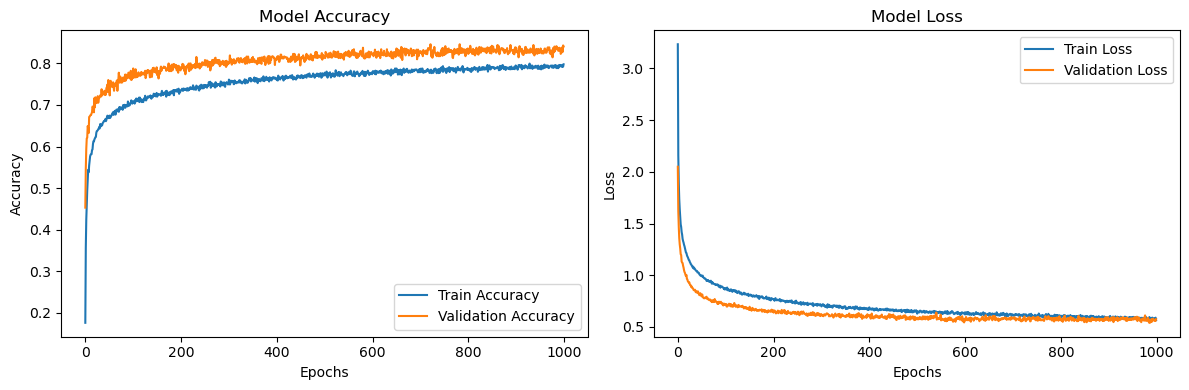

In [25]:
from sklearn.model_selection import train_test_split
import numpy as np
from scipy.signal import resample

# Assuming `patient_data` is a dictionary with patient IDs as keys and their corresponding 1-minute ECG windows as values.

# Convert the dictionary to lists for processing
X = []
y = []

for patient_id, windows in patient_data.items():
    for window in windows:
        
        window = resample(window, 3600)

        X.append(window)
        y.append(patient_id)

X = np.array(X)
y = np.array(y)
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, confusion_matrix, f1_score, accuracy_score
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Load your CNN model
cnn_model = tf.keras.models.load_model('final_non_overlapping.h5', compile=False)

# Reshape the ECG data
ptbxl_X = X.reshape(-1, 3600, 1)
ptbxl_y = y

# Adjust the labels to start from 0
ptbxl_y = ptbxl_y 

# Apply Label Encoding to convert class labels into integers
label_encoder = LabelEncoder()
ptbxl_y_encoded = label_encoder.fit_transform(ptbxl_y)

# Split the data
ptb_X_train, ptb_X_test, ptb_y_train, ptb_y_test = train_test_split(ptbxl_X, ptbxl_y_encoded, test_size=0.2, random_state=42)



# Generate embeddings for the train and test sets
embeddings_train = generate_embeddings(cnn_model, ptb_X_train)
embeddings_test = generate_embeddings(cnn_model, ptb_X_test)


# Get the number of classes from the unique labels
num_classes = len(np.unique(ptb_y_train))

# Build and compile the neural network classifier
nn_classifier = build_nn_classifier(input_shape=(embeddings_train.shape[1],), num_classes=num_classes)
nn_classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#  Train the neural network classifier on the embeddings
history = nn_classifier.fit(embeddings_train, ptb_y_train, epochs=1000, batch_size=32, validation_split=0.1)

#  Use the neural network model to predict the class of each test embedding
predicted_labels = np.argmax(nn_classifier.predict(embeddings_test), axis=1)

# Decode the predicted labels back to original form (optional)
predicted_labels_decoded = label_encoder.inverse_transform(predicted_labels)
ptb_y_test_decoded = label_encoder.inverse_transform(ptb_y_test)

#  Calculate accuracy, precision, recall, and confusion matrix
accuracy = accuracy_score(ptb_y_test_decoded, predicted_labels_decoded)
precision = precision_score(ptb_y_test_decoded, predicted_labels_decoded, average='macro')
recall = recall_score(ptb_y_test_decoded, predicted_labels_decoded, average='macro')
f1_score_ = f1_score(ptb_y_test_decoded, predicted_labels_decoded, average='macro')
conf_matrix = confusion_matrix(ptb_y_test_decoded, predicted_labels_decoded)

# Print the evaluation metrics
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("F1 Score: {:.2f}".format(f1_score_))
print("Confusion Matrix:\n", conf_matrix)

#  Plot the training history (accuracy and loss)
plt.figure(figsize=(12, 4))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


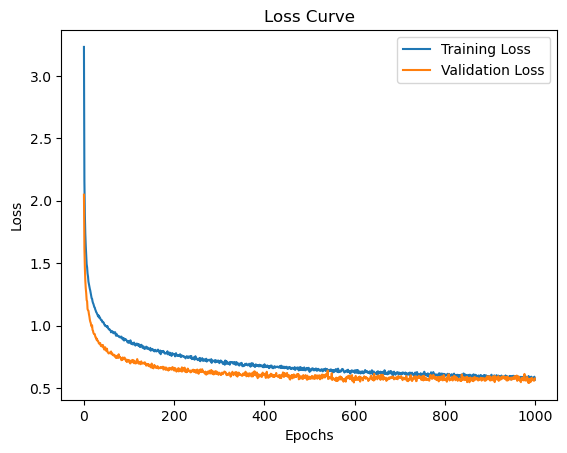

In [26]:
# Plotting the loss curves

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()